In [46]:
# Operating System
import os

import pickle
import json

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

# from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
# from sklearn.base import TransformerMixin, BaseEstimator

# import category_encoders as ce
# from sklearn.preprocessing import KBinsDiscretizer, Binarizer

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

# # Custom transformers
# from custom_transformers.transformer import Selector, TextSelector, NumberSelector, BoolSelector, TextCleanerTransformer

# #CURL requests
# import requests 

#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# # Statistics
# from scipy.stats import binom_test

# Strings
import re


# Load data

In [2]:
file_path = os.path.join('heroku', 'heroku_db', 'heroku_complete_db.csv')

df_results = pd.read_csv(file_path,
                         sep=";",
                         # nrows = 100, 
                         header=0,
                         warn_bad_lines=True)



In [3]:
df_results.head()

,id,observation_id,observation,proba,true_class
0,3,0,"{""id"": 0, ""observation"": {""Department Name"": ""...",0.456029,0.0
1,4,1,"{""id"": 1, ""observation"": {""Department Name"": ""...",0.456029,0.0
2,5,2,"{""id"": 2, ""observation"": {""Department Name"": ""...",0.490537,1.0
3,6,3,"{""id"": 3, ""observation"": {""Department Name"": ""...",0.490537,1.0
4,7,4,"{""id"": 4, ""observation"": {""Department Name"": ""...",0.000000,0.0


In [4]:
observations_decoupled = df_results['observation'].apply(json.loads).apply(pd.Series)

In [5]:
observations_decoupled.head()

,id,observation
0,0,"{'Department Name': 'Vernon', 'InterventionDat..."
1,1,"{'Department Name': 'Vernon', 'InterventionDat..."
2,2,"{'Department Name': 'Milford', 'InterventionDa..."
3,3,"{'Department Name': 'Milford', 'InterventionDa..."
4,4,"{'Department Name': 'Norwalk', 'InterventionDa..."


In [6]:
df_obs = pd.DataFrame(list(observations_decoupled.observation), index=observations_decoupled.id)

In [7]:
df_obs.head()

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
id,,,,,,,,,,,,,
0,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
1,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
2,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
3,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
4,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True


In [8]:
df_obs['proba'] = df_results['proba']

In [9]:
df_obs['true_class'] = df_results['true_class']

In [10]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 900003
Data columns (total 15 columns):
Department Name                     10002 non-null object
InterventionDateTime                10002 non-null object
InterventionLocationName            10002 non-null object
InterventionReasonCode              10002 non-null object
ReportingOfficerIdentificationID    10002 non-null object
ResidentIndicator                   10002 non-null bool
SearchAuthorizationCode             10002 non-null object
StatuteReason                       10002 non-null object
SubjectAge                          10002 non-null float64
SubjectEthnicityCode                10002 non-null object
SubjectRaceCode                     10002 non-null object
SubjectSexCode                      10002 non-null object
TownResidentIndicator               10002 non-null bool
proba                               10000 non-null float64
true_class                          5000 non-null float64
dtypes: bool(2), float

# Metrics

In [51]:
decision_thr = 0.5

In [52]:
y_true = df_obs.dropna().true_class.astype(int)
y_pred = df_obs.dropna().proba.apply(lambda x: x > decision_thr).astype(int)
y_prob = df_obs.dropna().proba

In [53]:
precision = precision_score(y_true, y_pred)
precision

0.6005416384563304

In [54]:
recall = recall_score(y_true, y_pred)
recall

0.49415041782729807

In [55]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.7004

# Curves

In [56]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
AUROC = roc_auc_score(y_true, y_prob)*100

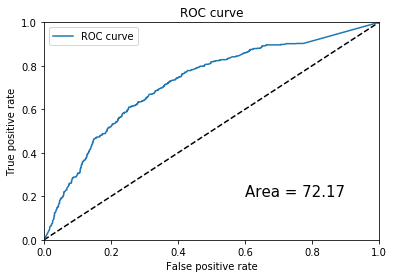

In [57]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.legend(loc='best')
plt.show()

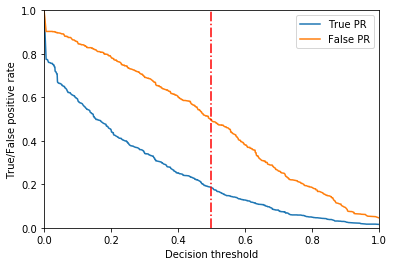

In [58]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='True PR')
plt.plot(thresholds_roc, tpr, label='False PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
#plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [59]:
precision_vec, recall_vec, thresholds_pr = precision_recall_curve(y_true, y_prob)

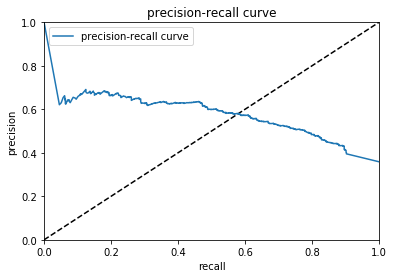

In [60]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_vec, precision_vec, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()